In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics


import os, glob, inspect, sys


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/marie-anne/code/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# K-means clustering with simulated data

As an alternative to handling the uncertainty of the measurements mathematically when clustering, we can use data that was simulated to reflect the uncertainty of the measurements to train the model on. This should lead to a similar result even though it uses a different method. This also allows us to use more classical approaches to clustering and cluster evaluation.

### Import data

This data was simulated with 1000 replicates per condition based on the observed data. Details can be found in the notebook NB/NB_modeling/sample_generation.ipynb

In [54]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_simulated.csv'), 
                 index_col=0)
df.head(20)

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,A,B,p,Absorption_avg_100,Absorption_avg_200,mean_CF,mean_perm,mean_MBN
Condition,,,,,,,,,,,,
T_B1,12.887224,0.000252,0.020317,0.001931,1.202073e-07,0.001092,0.221759,0.000886,0.000301,1.087656,68.832934,0.453917
T_B1,12.904167,0.000194,0.011580,0.001121,2.614525e-08,0.000801,0.214616,0.000605,0.000316,1.094037,67.753088,0.435966
T_B1,12.848012,0.000247,0.027738,0.001309,-3.440295e-07,0.000691,0.173157,0.000556,0.000428,1.098203,67.872952,0.539143
T_B1,12.968064,0.000210,0.019859,0.001921,-5.656336e-07,0.000864,0.213791,0.000746,0.000602,1.117724,65.970169,0.301158
T_B1,12.927068,0.000233,0.013641,0.001425,4.191747e-07,0.000408,0.192750,0.000777,0.000419,1.095836,68.614324,0.472276
T_B1,12.922867,0.000247,0.020506,0.002096,3.449743e-07,0.000829,0.222178,0.000744,0.000348,1.082900,69.855711,0.558925
T_B1,12.963778,0.000225,0.017784,0.000878,-2.451616e-07,0.000893,0.199752,0.000831,0.000387,1.110670,68.026524,0.555126
T_B1,13.002144,0.000195,0.023115,0.001159,4.347340e-07,0.000925,0.235891,0.000697,0.000553,1.105221,68.547524,0.490222
T_B1,12.895528,0.000230,0.014882,0.000627,1.366459e-07,0.001133,0.198817,0.000757,0.000349,1.110950,69.073188,0.407439


### Calculating new values

The AUC was calculated and the parameters were dropped.

In [55]:
df["AUC_avg"] = mc.findAUC(df, df['A'], df['B'], df['p'])
df.drop(columns=["A","B","p",'Absorption_avg_500','Absorption_avg_200'],inplace=True)
df

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,Absorption_avg_100,mean_CF,mean_perm,mean_MBN,AUC_avg
Condition,,,,,,,,
T_B1,12.887224,0.020317,0.001931,0.000886,1.087656,68.832934,0.453917,6.915891
T_B1,12.904167,0.011580,0.001121,0.000605,1.094037,67.753088,0.435966,5.736112
T_B1,12.848012,0.027738,0.001309,0.000556,1.098203,67.872952,0.539143,4.405958
T_B1,12.968064,0.019859,0.001921,0.000746,1.117724,65.970169,0.301158,5.334051
T_B1,12.927068,0.013641,0.001425,0.000777,1.095836,68.614324,0.472276,4.507867
...,...,...,...,...,...,...,...,...
T_HAZ_T,12.948355,0.020244,0.001145,0.000768,1.103950,71.464349,0.467974,6.263050
T_HAZ_T,12.940969,0.022487,0.000813,0.000688,1.110538,67.600032,1.204113,3.163240
T_HAZ_T,13.038192,0.029502,0.001371,0.000481,1.096371,66.768605,0.883852,5.939917


Optional calculate the CF/perm ratio

In [56]:
#df['CF_perm'] = df['mean_CF']/df['mean_perm'].astype('float64')
# df.drop(columns=["mean_MBN","mean_perm","mean_CF"],inplace=True)

### Scaling values and selecting subsamples

In [57]:
df_known = df.iloc[8000:,]
scaled_known, scaler_known = mc.scale_general(df_known, MinMaxScaler())

In [58]:
scaled_df = mc.scale_general(df, MinMaxScaler())[0]

tube, pipe, scaled_known, scaled_unknown = mc.get_subsample_df(scaled_df)

In [60]:
scaled_known.head()

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,Absorption_avg_100,mean_CF,mean_perm,mean_MBN,AUC_avg
Condition,,,,,,,,
T_AR,0.813160,0.436826,0.277662,0.497159,0.164236,0.339836,0.487944,0.249895
T_AR,0.872249,0.152230,0.345925,0.516215,0.173974,0.344293,0.497812,0.306792
T_AR,0.808830,0.397418,0.242341,0.604257,0.174547,0.346282,0.455263,0.255447
T_AR,0.891375,0.377264,0.336993,0.469086,0.163750,0.343022,0.486127,0.293363
T_AR,0.889685,0.382705,0.252036,0.378002,0.179080,0.341161,0.421521,0.199059


In [61]:
scaled_unknown.head()

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,Absorption_avg_100,mean_CF,mean_perm,mean_MBN,AUC_avg
Condition,,,,,,,,
T_B1,0.867389,0.398567,0.371884,0.448386,0.137143,0.420772,0.434427,0.299520
T_B1,0.873593,0.249685,0.264753,0.355158,0.138583,0.408741,0.427833,0.257246
T_B1,0.853029,0.525029,0.289641,0.338891,0.139523,0.410076,0.465733,0.209584
T_B1,0.896992,0.390772,0.370632,0.402020,0.143928,0.388876,0.378313,0.242839
T_B1,0.881979,0.284809,0.304966,0.412269,0.138989,0.418336,0.441171,0.213235


In [65]:
scaled_df['CF_perm'] = scaled_df['mean_CF']/scaled_df['mean_perm'].astype('float64')

corr_scaled_df = scaled_df.copy().loc[:,mc.correlation_list]
tube_scaled_corr, pipe_scaled_corr, \
tube_wo_blind_scaled_corr, tube_blind_scaled_corr = mc.get_subsample_df(corr_scaled_df)

In [63]:
mini_scaled_df = scaled_df.copy().loc[:,mc.minimal_informative_features]
tube_scaled_mini, pipe_scaled_mini, \
tube_wo_blind_scaled_mini, tube_blind_scaled_mini = mc.get_subsample_df(mini_scaled_df)

In [64]:
mini_df = df.copy().loc[:,mc.minimal_informative_features]
tube_mini, pipe_mini, \
tube_wo_blind_mini, tube_blind_mini = mc.get_subsample_df(mini_df)

## Visualization of PCA

To see what the uncertainty of the data looks like in terms of their distribution, principal component analysis was done with the simulated data and the first two components were plotted followed by the third and fourth components. The Last two components only explain a small amount of the variation. First this is done for the known tubes.

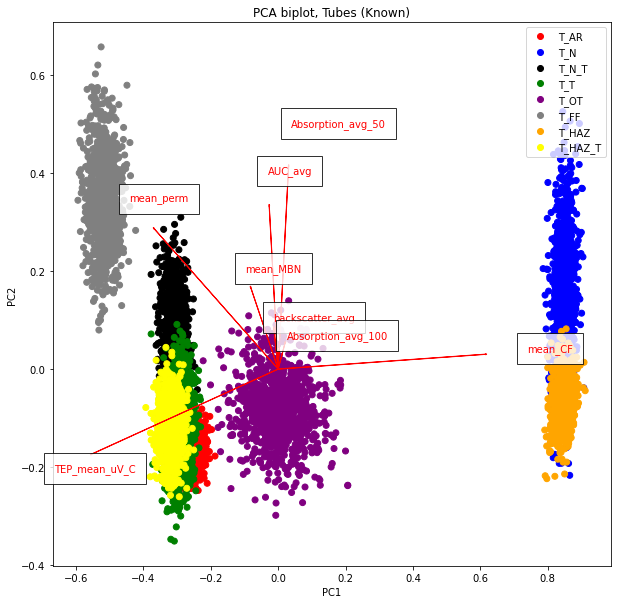

In [12]:
pca = PCA(n_components=4, svd_solver='full')
pca.fit(scaled_known)

color_dict = { 'T_AR':'red', 'T_N':'blue', 'T_N_T':'black', 'T_T':'green','T_OT':'purple',
             'T_FF':'grey', 'T_HAZ':'orange', 'T_HAZ_T':'yellow' }

mc.biplot(pca, scaled_known, 0, 1, "PCA biplot, Tubes (Known)", color_dict)

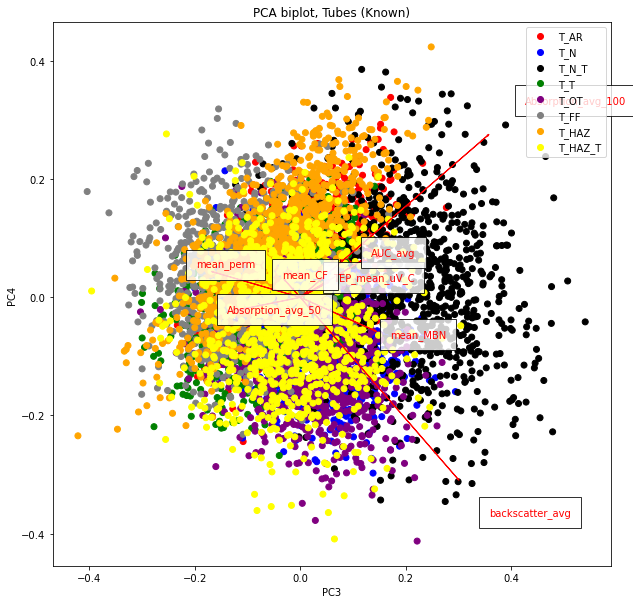

In [13]:
mc.biplot(pca, scaled_known, 2, 3, "PCA biplot, Tubes (Known)", color_dict)

Next we repeat for the unknown tubes, which were transformed using the same PCA fit as the known tubes. There seems to be 3 samples that cannot be told apart, but there are possible identifications for the others. 

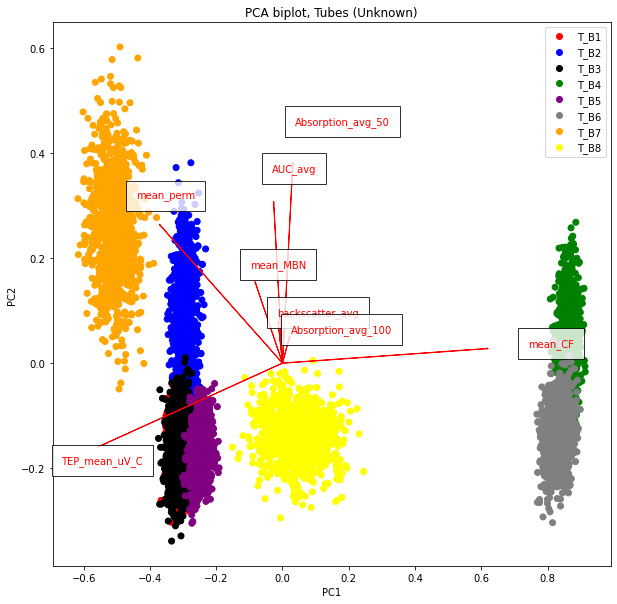

In [14]:
pca.transform(scaled_unknown)

color_dict = { 'T_B1':'red', 'T_B2':'blue', 'T_B3':'black', 'T_B4':'green','T_B5':'purple',
             'T_B6':'grey', 'T_B7':'orange', 'T_B8':'yellow' }

mc.biplot(pca, scaled_unknown, 0, 1, "PCA biplot, Tubes (Unknown)", color_dict)

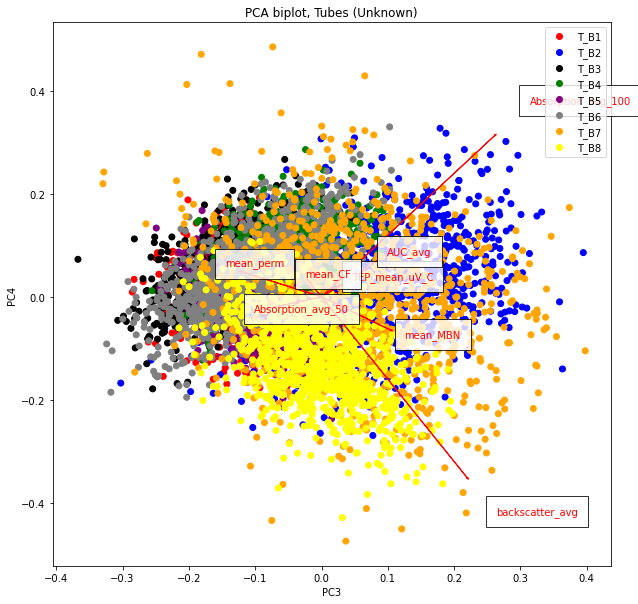

In [15]:
mc.biplot(pca, scaled_unknown, 2, 3, "PCA biplot, Tubes (Unknown)", color_dict)

Of the blind microstructure samples that were identified based on a single measurement in the previous reports, 4 are identified using this method, 1 additional sample is potentially identified, and one previously identified sample could not be identified. But is should be noted that this is based on the first two principal components alone so a full  model would presuably have more power.

In agreement with previous reports:
* FF=B7
* OT=B8
* N=B4
* HAZ=B6

Identified in previous report but not here:
* AR=B5

Identified here but not in previous reports:
* N_T=B2

## K-means Clustering

### Elbow method

First this tries to find a reasonable k automatically in the classic way. This doesn't work well.

In [16]:
min_range = 2
max_range = 8

def plot_elbow_kmeans(feat_norm, title):
    '''
    Elbow plot
    Args:
    - feat_norm : pandas dataframe
    - title : title of the figure ideally correpond to the samples
    return plot
    '''
    
    inertia = []
    k_list = range(min_range, max_range+1)

    for k in k_list:
        km = KMeans(n_clusters = k, random_state= 0)
        km.fit(feat_norm) 
        score = km.inertia_
        inertia.append(score)


    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(min_range , max_range+1) , inertia , 'o')
    plt.plot(np.arange(min_range , max_range+1) , inertia , '-' , alpha = 0.5)

    plt.xlabel('Number of Clusters', fontsize=20) , plt.ylabel('Inertia', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

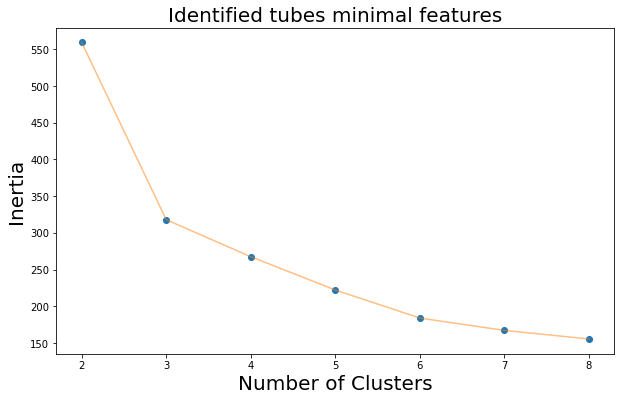

In [17]:
plot_elbow_kmeans(tube_wo_blind_scaled_mini, title='Identified tubes minimal features')

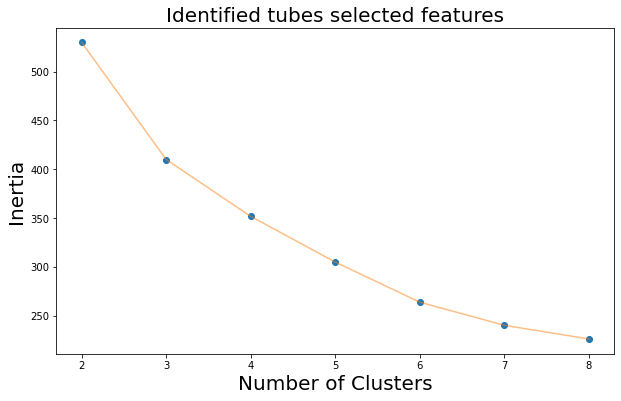

In [18]:
plot_elbow_kmeans(tube_wo_blind_scaled_corr, title='Identified tubes selected features')

### Auto find K
Source: https://jtemporal.com/kmeans-and-elbow-method/

In [19]:
def calculate_wcss(data):
    '''
    Calculate within class sum-squared value which represents loss in KMeans clustering
    '''
    wcss = []
    for n in range(min_range, max_range):
        kmeans = KMeans(n_clusters=n,random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    return wcss

from math import sqrt

def optimal_number_of_clusters(wcss):
    '''
    Calculate normal distance 
    '''
    x1, y1 = min_range, wcss[0]
    x2, y2 = max_range, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2
    

In [20]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(tube_wo_blind_scaled_corr)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number of cluster =', n)

Number of cluster = 4


In [21]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(tube_wo_blind_scaled_mini)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number of cluster for all tubes =', n)

Number of cluster for all tubes = 3


### Plot K-Means on sample distribution scatterplot

In [22]:
def plot_kmeans(df_scaled, df_ori, k):
    '''
    Scatter plot
    Args:
    - df : scaled pandas dataframe
    - range_col : np.r_[range of column wanted]
    return plot
    '''
    model = KMeans(n_clusters = k, random_state= 42)
    model.fit(df_scaled) 
    labels = model.predict(df_scaled)
    print(labels)
    silhouette = metrics.silhouette_score(df_scaled, labels, metric='euclidean')
    print(silhouette)
    df_ori['labels'] = labels
    sns.pairplot(df_ori, hue='labels')

[2 2 2 ... 0 2 2]
0.44004825706208023


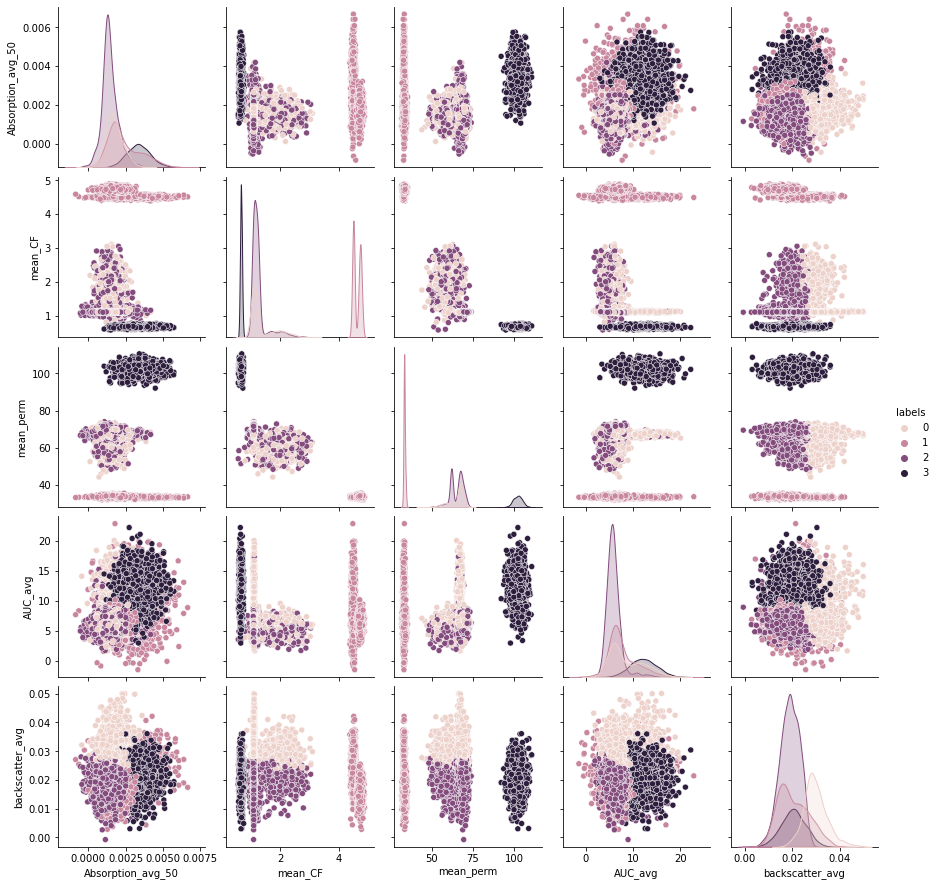

In [23]:
plot_kmeans(tube_wo_blind_scaled_mini, tube_wo_blind_mini, 4)

## Choosing k visually

The elbow method gives relatively low values of k even though more clusters are clerly separable based on the PCA visualization. Instead, this simply plots the PCA and colors the points based on the clustering with different values of k to see whether it can identify the actual conditions. In fact with k=6 the model is able to roughly identify the known clusters. 

In [24]:

pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(scaled_known)

color_dict = { 0:'cyan', 1:'burlywood', 2:'pink', 3:'silver', 4:'khaki', 5:'palegreen', 6:'steelblue', 7:'plum'}

plot_scaled = scaled_known.copy()


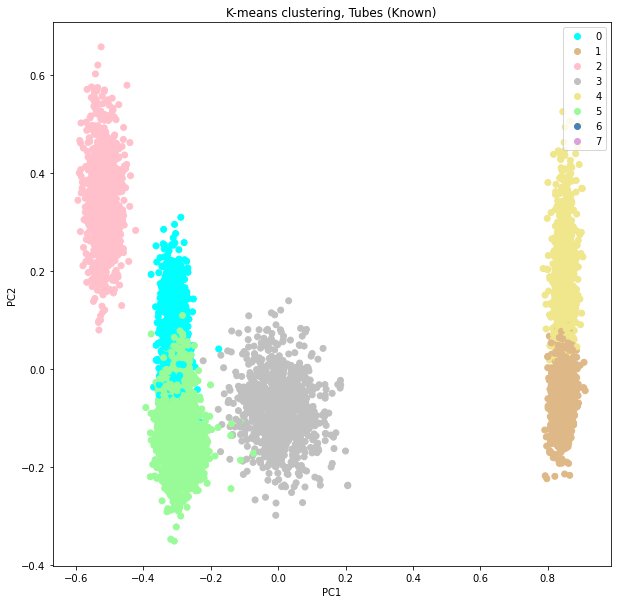

In [25]:
model = KMeans(n_clusters = 6, random_state= 42)
model.fit(scaled_known) 
labels = model.labels_
plot_scaled.index = labels
mc.biplot(pca, plot_scaled, 0, 1, "K-means clustering, Tubes (Known)", color=color_dict, plot_vectors=False)

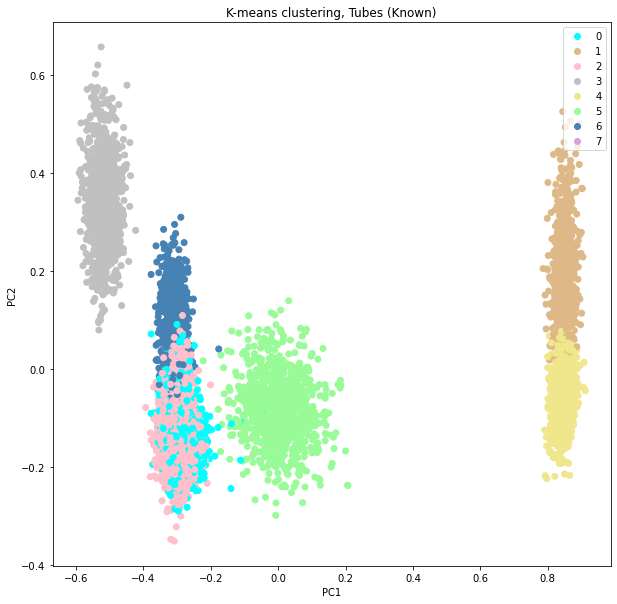

In [26]:
model = KMeans(n_clusters = 7, random_state= 42)
model.fit(scaled_known) 
labels = model.labels_
plot_scaled.index = labels
mc.biplot(pca, plot_scaled, 0, 1, "K-means clustering, Tubes (Known)", color=color_dict, plot_vectors=False)

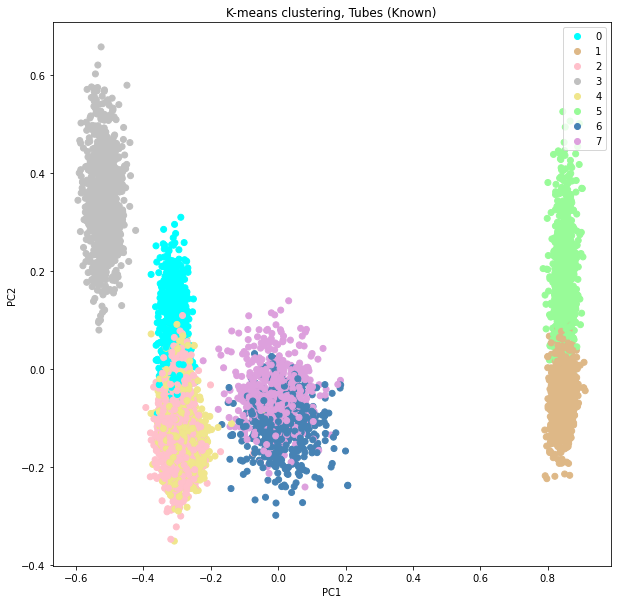

In [27]:
model = KMeans(n_clusters = 8, random_state= 42)
model.fit(scaled_known) 
labels = model.labels_
plot_scaled.index = labels
mc.biplot(pca, plot_scaled, 0, 1, "K-means clustering, Tubes (Known)", color=color_dict, plot_vectors=False)

## Classify original blind samples with k-means

For this the original 8 samples of known and unknown tubes are classified with the model built using simulated data. This does not take into account the uncertainty of the blind data. 

In [66]:
data_path = "../../Data/Merged_data"
df_original = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_merge_1.csv'), 
                 index_col=0)
df_original["AUC_avg"] = mc.findAUC(df_original, df_original['A'], df_original['B'], df_original['p'])
df_original.drop(columns=["median_CF","median_perm","median_MBN","A","B","p",'Absorption_avg_500','Absorption_avg_200']+mc.errors_list,inplace=True)
df_original = df_original.iloc[:16,]
df_original.dropna(axis=1, inplace=True)
scaled_original = mc.scale_general(df_original,MinMaxScaler())[0]

In [67]:
model = KMeans(n_clusters = 6, random_state= 42)
model.fit(scaled_known) 
model.predict(scaled_original)

array([5, 0, 5, 1, 5, 1, 2, 3, 5, 4, 0, 5, 3, 2, 1, 5], dtype=int32)

In [68]:
scaled_original

,TEP_mean_uV_C,backscatter_avg,Absorption_avg_50,Absorption_avg_100,mean_CF,mean_perm,mean_MBN,AUC_avg
T_B1,0.988176,0.246988,0.135434,0.154523,0.105783,0.512372,0.296398,0.121734
T_B2,0.975563,0.638554,0.635434,0.695701,0.107546,0.483943,0.494604,0.711703
T_B3,0.981352,0.000000,0.096154,0.121720,0.100692,0.513688,0.477732,0.095747
T_B4,0.000000,0.072289,0.470949,0.488414,0.942844,0.000000,0.345341,0.412343
T_B5,0.985918,0.289157,0.085106,0.000000,0.187319,0.467491,0.381669,0.161530
T_B6,0.124090,0.084337,0.159574,0.344919,0.990891,0.014872,0.000000,0.000000
T_B7,0.958410,1.000000,0.398936,0.617951,0.002188,0.972493,0.501292,1.000000
T_B8,0.675966,0.813253,0.000000,0.063791,0.351574,0.350619,0.178447,0.190805
T_AR,0.987760,0.271084,0.132570,0.574400,0.139116,0.420900,0.481532,0.092455
T_N,0.018823,0.716867,0.898118,0.541039,0.941460,0.005528,0.470436,0.424761


The clusters created are:

* 0: N_T, B2
* 1: N, 
* 2: AR, HAZ_T, T, B1, B3, B5
* 3: FF, B7
* 4: HAZ, B6, B4
* 5: OT, B8

In agreement with previous reports:
* FF=B7
* OT=B8
* HAZ=B6

Identified in previous report but not here:
* AR=B5

Identified here but not in previous reports:
* N_T=B2

Problems:
* B4 corresponds to N but its uncertainty overlaps with HAZ and is incorrectly grouped there

This methods handles well the uncertainty of the training data but does not handle the uncertainty of the prediction data of the blind tubes causing a misclassification. We may need a way to compare between two sample distributions instead. Reducing the uncertainty would also allow the clusters to be more easily separated. 

## A minimal feature set

Since many of the features are correlated and contribute similarly to the PCA this tries to find a minimum that can recreate the same result. Features were individually dropped and their effect on the principal components were observed. The features with minimal effect on the components were removed.

In [69]:
minimal_set_known = scaled_known.copy()[["TEP_mean_uV_C","Absorption_avg_50","mean_perm","AUC_avg","backscatter_avg"]]
minimal_original = scaled_original[["TEP_mean_uV_C","Absorption_avg_50","mean_perm","AUC_avg","backscatter_avg"]]


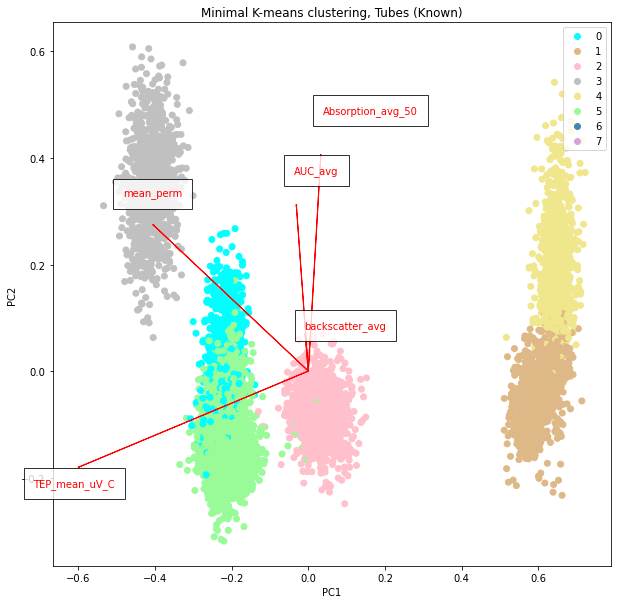

In [70]:
pca = PCA(n_components=4, svd_solver='full')
pca.fit(minimal_set_known)

color_dict = { 0:'cyan', 1:'burlywood', 2:'pink', 3:'silver', 4:'khaki', 5:'palegreen', 6:'steelblue', 7:'plum'}

plot_scaled = minimal_set_known.copy()

model = KMeans(n_clusters = 6, random_state= 42)
model.fit(minimal_set_known) 
labels = model.labels_
plot_scaled.index = labels
mc.biplot(pca, plot_scaled, 0, 1, "Minimal K-means clustering, Tubes (Known)", color_dict)

In [71]:
model.predict(minimal_original)

array([5, 0, 5, 1, 5, 1, 3, 2, 5, 4, 0, 5, 2, 3, 1, 5], dtype=int32)

The clusters are:

* 0: B1, B3, B5, AR, HAZ_T, T
* 1: B4, B6, HAZ
* 2: B7, FF
* 3: B2, N_T
* 4: N
* 5: B8, OT

These predictions are identical to what was made with the full model. This may represent a minimal feature set that contains the majority of the information.


## Feature importance

The first two principal components (and especially the first) explain the majority of the variance. The first component is largely made up of TEP and permeability. All the features except backscatter contribute to the second component and backscatter contributes to the third component.

In [72]:
pca.explained_variance_ratio_

array([0.70612149, 0.16047897, 0.0666771 , 0.04076117])

Text(0, 0.5, 'Explained variance')

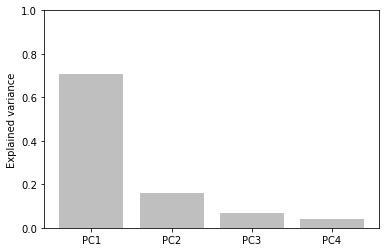

In [73]:
plt.bar(["PC1","PC2","PC3","PC4"],pca.explained_variance_ratio_, align='center', alpha=0.5, color="gray")
plt.ylim(0,1)
plt.ylabel("Explained variance")

In [74]:
pca.explained_variance_ratio_

array([0.70612149, 0.16047897, 0.0666771 , 0.04076117])

In [75]:
pca.components_

array([[-0.82722393,  0.04473318, -0.5583094 , -0.04313718, -0.01137196],
       [-0.29552343,  0.66277098,  0.44937443,  0.50903394,  0.11111976],
       [ 0.10921976, -0.09639814, -0.20121864,  0.15793281,  0.95569175],
       [-0.02777157, -0.55539038, -0.06147424,  0.80466372, -0.19876488]])

In [76]:
feature_importance = pd.DataFrame([x*abs(y) for x,y in zip(pca.explained_variance_ratio_, pca.components_)],columns=minimal_set_known.columns, index=["PC1","PC2","PC3","PC4"] )

In [98]:
feature_importance

,PC1,PC2,PC3,PC4
TEP_mean_uV_C,0.584121,0.047425,0.007282,0.001132
Absorption_avg_50,0.031587,0.106361,0.006428,0.022638
mean_perm,0.394234,0.072115,0.013417,0.002506
AUC_avg,0.030460,0.081689,0.010531,0.032799
backscatter_avg,0.008030,0.017832,0.063723,0.008102


In [104]:
plot_feat_imp = feature_importance.transpose().sort_values('PC1', ascending=False).transpose()

Text(0.5, 0, 'Feature importance (explained variance ratio)')

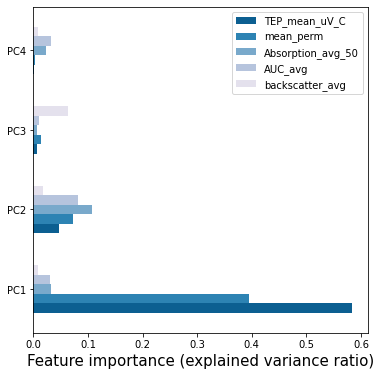

In [124]:
plot_feat_imp.plot(kind='barh', color=sns.color_palette('PuBu_r', 5, desat=0.9), width=0.6, figsize=(6,6))
plt.xlabel('Feature importance (explained variance ratio)', fontsize = 15)

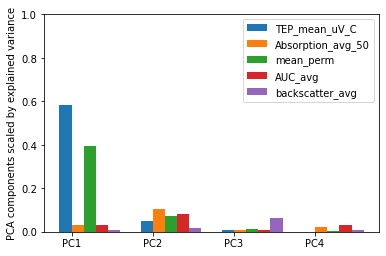

In [92]:
N = 4

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.15         # the width of the bars

pca_components = ["PC1","PC2","PC3","PC4"]

for i in range(5):
    ax.bar(ind + width*i, feature_importance.iloc[:,i], width, label=feature_importance.columns[i])

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(pca_components)
plt.ylim(0,1)
plt.ylabel('PCA components scaled by explained variance')
ax.legend()

In [89]:
feature_importance.iloc[:,i]

PC1    0.008030
PC4    0.008102
PC2    0.017832
PC3    0.063723
Name: backscatter_avg, dtype: float64